In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import torch

torch.cuda.set_device(5)
torch.cuda.current_device()

import warnings
from pathlib import Path
from types import SimpleNamespace
from wrappers.transformer_wrapper import FairseqTransformerHub

from wrappers.multilingual_transformer_wrapper import FairseqMultilingualTransformerHub
from fairseq.data.multilingual.multilingual_utils import (
    EncoderLangtok,
    LangTokSpec,
    LangTokStyle,
    augment_dictionary,
    get_lang_tok,
)

import wrappers.helper as helper
import alignment.align as align

import matplotlib.pyplot as plt
#plt.style.use('ggplot')
import seaborn as sns
import pandas as pd
import numpy as np
import json
import csv

from collections import defaultdict
import statistics

import logging
logger = logging.getLogger()

logger.setLevel('WARNING')
warnings.simplefilter('ignore')

plt.rcParams.update({'font.size': 30})
plt.rcParams.update({'xtick.labelsize' : 20})
plt.rcParams.update({'ytick.labelsize' : 20})
plt.rcParams.update({'axes.titlesize' : 24})
plt.rcParams.update({'axes.labelsize' : 22})

from dotenv import load_dotenv
load_dotenv()
device = "cuda" if torch.cuda.is_available() else "cpu"

## Load model

In [3]:
model = 'bilingual'# bilingual/multilingual
model_size = 'small'
teacher_forcing = False # teacher forcing/free decoding
dataset = 'iwslt'

In [4]:
if model == 'bilingual':
    # Bilingual paths
    europarl_dir = Path(os.environ['EUROPARL_DATA_DIR'])
    ckpt_dir = Path(os.environ['EUROPARL_CKPT_DIR'])
    iwslt14_dir = Path(os.environ['IWSLT14_DATA_DIR']) / "tokenized"
    pre_layer_norm = False
    tokenizer = "bpe"
    #gold_dir = Path(os.environ['GOLD_ALIGNMENT_DATA_DIR'])

elif model == 'multilingual':
    # Multilingual paths
    ckpt_dir = Path(os.environ['M2M_CKPT_DIR'])
    iwslt14_dir = Path("./data/iwslt14")
    europarl_dir = Path("./data/de-en")
    flores_dir = Path("./data/flores")
    pre_layer_norm = True
    tokenizer ="spm"

if dataset == 'iwslt':
    test_set_dir = iwslt14_dir
elif dataset == 'gold':
    test_set_dir = europarl_dir / "processed_data/"
elif dataset == 'flores':
    test_set_dir = flores_dir

In [5]:
#ckpt_dir = Path(os.environ['IWSLT14_CKPT_DIR'])

lang_flores_dict = {'en': 'eng', 'es': 'spa', 'zu': 'zul',
                    'de': 'deu', 'yo': 'yor', 'ms': 'msa',
                    'fr': 'fra', 'xh': 'xho'}
source_lang = 'en'
target_lang = 'es'
if model == 'bilingual':
    # Choose model
    model_type = 'baseline'
    seed = 5498 # 2253  2453  5498  9240  9819

    hub = FairseqTransformerHub.from_pretrained(
        ckpt_dir / f"{model_type}/{seed}",
        checkpoint_file=f"checkpoint_best.pt",
        data_name_or_path=(europarl_dir / "processed_data/fairseq_preprocessed_data").as_posix(), # processed data
        #(data_name_or_path=iwslt14_dir / "data-bin").as_posix(), 
    )
    NUM_LAYERS = 6

elif model == 'multilingual':
    # Checkpoint names
    if model_size=='big':
        checkpoint_file = '1.2B_last_checkpoint.pt'
    else:
        checkpoint_file = '418M_last_checkpoint.pt'
    data_name_or_path='.'
    hub = FairseqMultilingualTransformerHub.from_pretrained(
        ckpt_dir,
        checkpoint_file=checkpoint_file,
        data_name_or_path=data_name_or_path,
        source_lang= source_lang,
        target_lang= target_lang,
        lang_pairs =f'{source_lang}-{target_lang}')
    NUM_LAYERS = 12


# Test set analysis

### Hallucinations Analysis

Save top 30 most common tokens from training data (Raunak et al., 2021)

In [ ]:
import csv
from collections import Counter

europarl_dir = Path(os.environ['EUROPARL_DATA_DIR'])
for lang in ['en', 'de']:
    with open(europarl_dir / f'processed_data/train.bpe.{lang}', encoding="utf-8") as fbpe:
        # BPE source sentences
        data_set = fbpe.read()

        split_it = data_set.split()
        counter_words = Counter(split_it)
        most_occur = counter_words.most_common(30)

        with open(f'results/top_30_{lang}.csv', 'w', encoding="utf-8") as csv_out:
            writer = csv.writer(csv_out)
            for row in most_occur:
                writer.writerow(row)
            #write.writerow(most_occur)


## Generate Translations

In [6]:
# from numba import jit
# @jit
def hallucination_translation(hub, args, number_sentences, hall_tokens, contributions):
    '''Gets list of standard translation, list of perturbed translations, and ALTI+ results.'''
    standard_translation_list = []
    perturbed_translation_dict = defaultdict(list) #dict of lists, each key (token), has a list of translations
    
    src_alti_perturbed_list = []
    src_alti_list = []

    for i in range(number_sentences):
        if i%10==0:
            print(i)
        # Standard translation
        pred_sent, src_total_alti  = helper.get_translation(hub, i, args, prefix_subwords=None,
                                                    contributions=contributions)
        standard_translation_list.append(pred_sent + '\n')
        if src_total_alti is not None:
            src_alti_list.append(torch.mean(src_total_alti).item()) # src_alti_list.append(src_total_alti.tolist())
            
            
        for token, _ in hall_tokens:
            # Perturbed translation
            pred_sent_perturbed, src_alti_perturbed  = helper.get_translation(hub, i, args, perturb_type=args.perturb_type,
                                                                        prefix_subwords=token, contributions=contributions)
            perturbed_translation_dict[token].append(pred_sent_perturbed + '\n')
            #perturbed_translation_src.write(pred_sent_perturbed + '\n')
            if src_alti_perturbed is not None:
                src_alti_perturbed_list.append(torch.mean(src_alti_perturbed).item())# src_alti_perturbed_list.append(src_alti_perturbed.tolist())
                

    return standard_translation_list, perturbed_translation_dict, (src_alti_list, src_alti_perturbed_list)

In [18]:
args = SimpleNamespace(
    src = "de",
    tgt = "en",
    tokenizer = tokenizer,
    test_set_dir = test_set_dir,
    perturb_type = "tgt", # perturb src or tgt
    pre_layer_norm = pre_layer_norm,
    beam = 1
    )
tuples_hall_tokens = [('▁unk',0)]
number_sentences = 100
contributions = True

translation_list, perturbed_translation_dict, tuple_alti_values = hallucination_translation(hub, args, 
                                                                                            number_sentences,
                                                                                            tuples_hall_tokens, contributions)

0


In [20]:
# Save perturbed translation
for token in perturbed_translation_dict.keys():
    perturbed_translation_src = open(f'results/{dataset}/translations_{args.perturb_type}_{token[1:]}_{number_sentences}.txt', 'w', encoding="utf-8")
    for i in range(len(perturbed_translation_dict[token])):
        perturbed_translation_src.write(perturbed_translation_dict[token][i])
    perturbed_translation_src.close()

## Save original translations
standard_translation = open(f'results/{dataset}/{args.src}_{args.tgt}_translations.txt', 'w', encoding="utf-8")
for i in range(number_sentences):
    standard_translation.write(translation_list[i])
standard_translation.close()

In [13]:
## Get standard alti results
with open(f'results/{dataset}/alti.csv', 'w') as f:
    write = csv.writer(f)
    for element in tuple_alti_values[0]:
        write.writerow([element])

alti_perturb = []
with open(f'results/{dataset}/{args.perturb_type}_alti_unk.csv', encoding="utf-8") as csvfile:
        # BPE source sentences
        reader = csv.reader(csvfile, delimiter =',', quoting=csv.QUOTE_NONNUMERIC)
        for i, line in enumerate(reader):
                alti_perturb.append(line)

In [12]:
args = SimpleNamespace(
    src = "de",
    tgt = "en",
    tokenizer = tokenizer,
    test_set_dir = test_set_dir,
    perturb_type = "tgt" # perturb src or tgt
    )

alti_original = []
with open(f'results/{dataset}/alti.csv', encoding="utf-8") as csvfile:
        # BPE source sentences
        reader = csv.reader(csvfile, delimiter =',', quoting=csv.QUOTE_NONNUMERIC)
        for i, line in enumerate(reader):
                alti_original.append(line)

alti_perturb = []
with open(f'results/{dataset}/{args.perturb_type}_alti_unk.csv', encoding="utf-8") as csvfile:
        # BPE source sentences
        reader = csv.reader(csvfile, delimiter =',', quoting=csv.QUOTE_NONNUMERIC)
        for i, line in enumerate(reader):
                alti_perturb.append(line)

In [13]:
#import sacrebleu
from sacrebleu.metrics import BLEU, CHRF, TER
import nltk
bleu = BLEU(max_ngram_order=4)
def compute_bleu(reference, candidate):
    return bleu.corpus_score([candidate],[[reference]]).score

def read_file(path):
    with open(path,'r') as f:
        return list(f.readlines())
#compute BLEU score against the reference for each baseline and model output
refs = []
model_translations = []

if dataset == 'gold':
    refs.append(read_file("data/de-en/test.en"))
else:
    refs.append(read_file(test_set_dir / "test.en"))

model_translations.append(read_file(f"results/{dataset}/translations.txt"))

diff_score = []
scores = []

for i in range(1000):# len(refs[0])
    for token in ['▁unk']:
        hallucinations = []
        hallucinations.append(read_file(f"results/{dataset}/translations_{args.perturb_type}_{token[1:]}.txt"))
    
        model_score = sum([compute_bleu(refs[j][i],model_translations[j][i]) for j in range(len(model_translations))])/len(model_translations)
        hallucinations_score = sum([compute_bleu(refs[j][i],hallucinations[j][i]) for j in range(len(hallucinations))])/len(hallucinations)
        diff_score.append((i,model_score-hallucinations_score))
        scores.append((i, model_score, hallucinations_score))
        if model_score > 0.2:
            if hallucinations_score < 0.03:
                print(token)
                print(i)
        #print('Computed score', i, model_score, hallucinations_score)
    #print('Computed score', i, model_score)

▁unk
50
▁unk
73
▁unk
275
▁unk
284
▁unk
293
▁unk
312
▁unk
505
▁unk
510
▁unk
516
▁unk
569
▁unk
636
▁unk
697
▁unk
825
▁unk
889
▁unk
915


In [19]:
# Apply algorithm for extracting hallucination
hallucination_set = []
for (i, model_score, hallucinations_score) in scores:
    if model_score > 0.2:
        if hallucinations_score < 0.03:
            hallucination_set.append(i)

In [20]:
len(hallucination_set)

15

In [21]:
hallucination_set

[50, 73, 275, 284, 293, 312, 505, 510, 516, 569, 636, 697, 825, 889, 915]

Text(0, 0.5, 'Source Contribution')

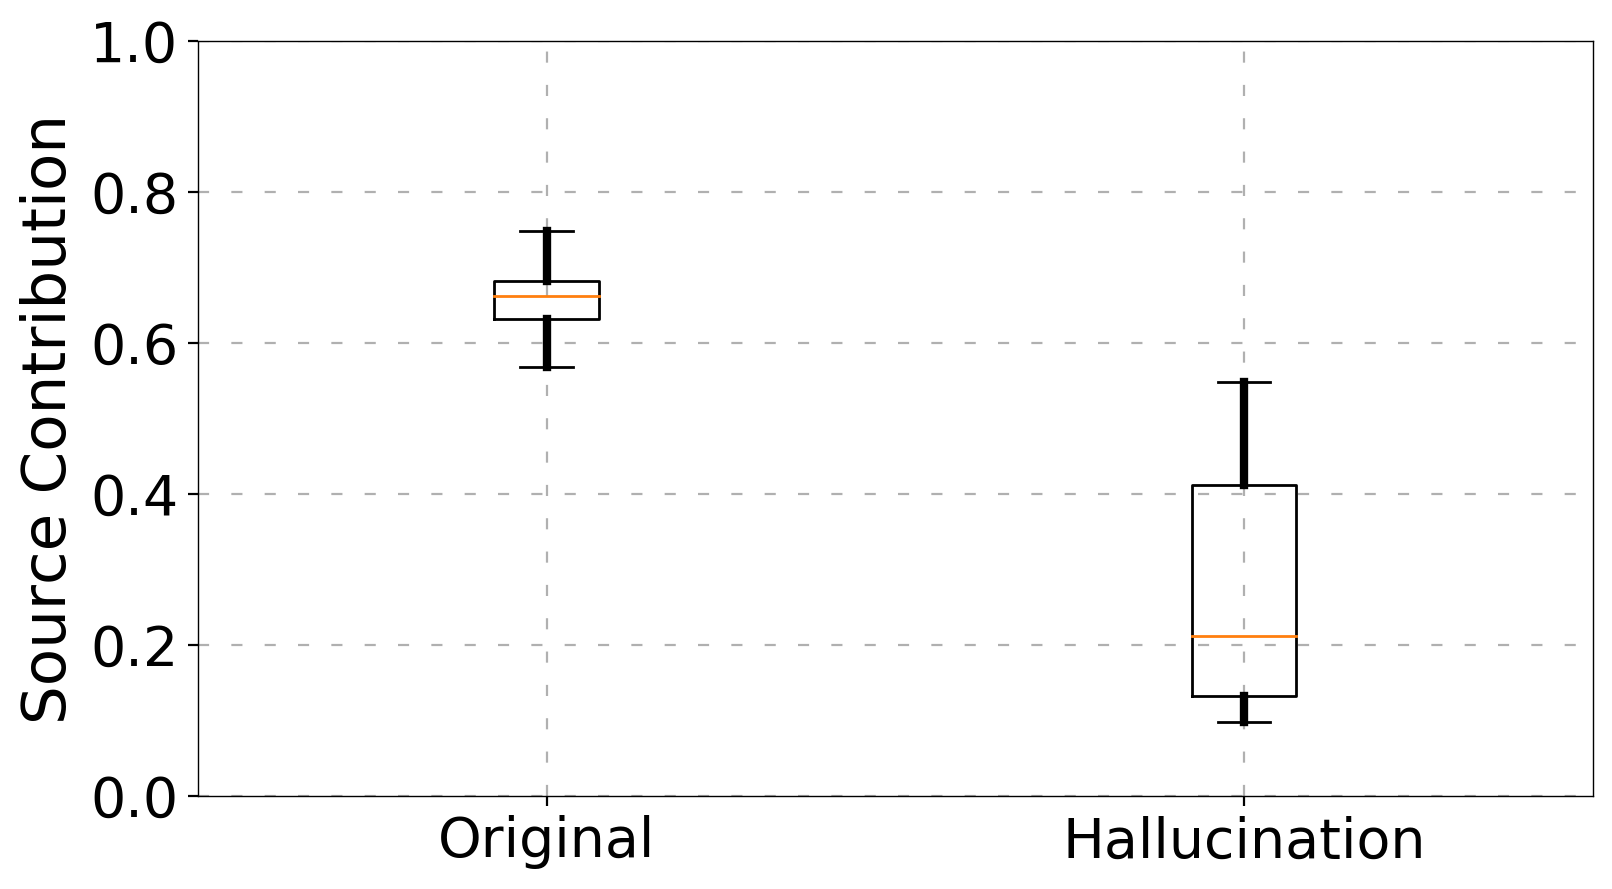

In [23]:
alti_original_flat = [item for sublist in alti_original for item in sublist]
alti_perturb_flat = [item for sublist in alti_perturb for item in sublist]

mean_src_alti = []
mean_preturbed_src_alti = []
mean_alti = defaultdict(list)
for i in hallucination_set:
    mean_alti['Original'].append(alti_original_flat[i])
    mean_alti['Hallucination'].append(alti_perturb_flat[i])

fig, ax = plt.subplots(figsize =(9, 5),dpi=200)
ax.boxplot(mean_alti.values(),whiskerprops=dict(linewidth=3.0))
ax.set_xticklabels(mean_alti.keys())
ax.set_ylim(0,1)
ax.grid(True, linestyle=(0, (5, 10)))
plt.ylabel(r'Source Contribution')


## Low-resource source contribution analysis

In [6]:
args = SimpleNamespace(
    src = lang_flores_dict[source_lang],
    tgt = lang_flores_dict[target_lang],
    tokenizer = tokenizer,
    test_set_dir = test_set_dir,
    pre_layer_norm=pre_layer_norm,
    beam = 1,
    num_layers = NUM_LAYERS
    )

## Get suitable flores sentences. Tokenized english sentences length <= 40
length_sen_eng = []
if source_lang == 'en':
    lang_max = target_lang
else:
    lang_max = source_lang
print('lang_max', lang_flores_dict[lang_max])
num_sentences = 1011 # 1011
for i in range(num_sentences):
    sample = hub.get_interactive_sample(i, Path("./data/flores"), lang_flores_dict[lang_max], 'eng', 'spm')
    src_tok_len = len(sample['src_tok'])
    if src_tok_len <= 50:
        length_sen_eng.append(i)
contributions = True

print('src', args.src)
print('tgt', args.tgt)
src_total_alti, number_hallucinations = helper.model_analysis(hub, length_sen_eng, args,
                                                        eos_res_corr=False, lang_toks=False,
                                                        src_contrib=True)
print('Total hallucinations:', number_hallucinations)

lang_max spa
src eng
tgt spa
100
200
300
400
500
600
700
800
Total hallucinations: 0


In [12]:
import csv
## Get standard alti results
with open(f'results/{dataset}/{args.src}_{args.tgt}_src_alti.csv', 'w') as f:
    write = csv.writer(f)
    for element in src_total_alti:
        write.writerow([element])

In [13]:
# for src in lang_flores_dict.keys():
#     for tgt in reversed(list(lang_flores_dict.keys())):
#         if src is not tgt:
#             print(src, tgt)


In [14]:
eng_zul = []
with open(f'results/{dataset}/eng_zul_src_alti.csv', encoding="utf-8") as csvfile:
        # BPE source sentences
        reader = csv.reader(csvfile, delimiter =',', quoting=csv.QUOTE_NONNUMERIC)
        for i, line in enumerate(reader):
                eng_zul.append(line)

zul_eng = []
with open(f'results/{dataset}/zul_eng_src_alti.csv', encoding="utf-8") as csvfile:
        # BPE source sentences
        reader = csv.reader(csvfile, delimiter =',', quoting=csv.QUOTE_NONNUMERIC)
        for i, line in enumerate(reader):
                zul_eng.append(line)

eng_spa = []
with open(f'results/{dataset}/eng_spa_src_alti.csv', encoding="utf-8") as csvfile:
        # BPE source sentences
        reader = csv.reader(csvfile, delimiter =',', quoting=csv.QUOTE_NONNUMERIC)
        for i, line in enumerate(reader):
                eng_spa.append(line)
spa_eng = []
with open(f'results/{dataset}/spa_eng_src_alti.csv', encoding="utf-8") as csvfile:
        # BPE source sentences
        reader = csv.reader(csvfile, delimiter =',', quoting=csv.QUOTE_NONNUMERIC)
        for i, line in enumerate(reader):
                spa_eng.append(line)
# eng_msa = []
# with open(f'results/{dataset}/eng_msa_src_alti.csv', encoding="utf-8") as csvfile:
#         # BPE source sentences
#         reader = csv.reader(csvfile, delimiter =',', quoting=csv.QUOTE_NONNUMERIC)
#         for i, line in enumerate(reader):
#                 eng_msa.append(line)
# msa_eng = []
# with open(f'results/{dataset}/msa_eng_src_alti.csv', encoding="utf-8") as csvfile:
#         # BPE source sentences
#         reader = csv.reader(csvfile, delimiter =',', quoting=csv.QUOTE_NONNUMERIC)
#         for i, line in enumerate(reader):
#                 msa_eng.append(line)

# msa_zul = []
# with open(f'results/{dataset}/msa_zul_src_alti.csv', encoding="utf-8") as csvfile:
#         # BPE source sentences
#         reader = csv.reader(csvfile, delimiter =',', quoting=csv.QUOTE_NONNUMERIC)
#         for i, line in enumerate(reader):
#                 msa_zul.append(line)

eng_yor = []
with open(f'results/{dataset}/eng_yor_src_alti.csv', encoding="utf-8") as csvfile:
        # BPE source sentences
        reader = csv.reader(csvfile, delimiter =',', quoting=csv.QUOTE_NONNUMERIC)
        for i, line in enumerate(reader):
                eng_yor.append(line)
yor_eng = []
with open(f'results/{dataset}/yor_eng_src_alti.csv', encoding="utf-8") as csvfile:
        # BPE source sentences
        reader = csv.reader(csvfile, delimiter =',', quoting=csv.QUOTE_NONNUMERIC)
        for i, line in enumerate(reader):
                yor_eng.append(line)
eng_fra = []
with open(f'results/{dataset}/eng_fra_src_alti.csv', encoding="utf-8") as csvfile:
        # BPE source sentences
        reader = csv.reader(csvfile, delimiter =',', quoting=csv.QUOTE_NONNUMERIC)
        for i, line in enumerate(reader):
                eng_fra.append(line)
fra_eng = []
with open(f'results/{dataset}/fra_eng_src_alti.csv', encoding="utf-8") as csvfile:
        # BPE source sentences
        reader = csv.reader(csvfile, delimiter =',', quoting=csv.QUOTE_NONNUMERIC)
        for i, line in enumerate(reader):
                fra_eng.append(line)
xho_eng = []
with open(f'results/{dataset}/xho_eng_src_alti.csv', encoding="utf-8") as csvfile:
        # BPE source sentences
        reader = csv.reader(csvfile, delimiter =',', quoting=csv.QUOTE_NONNUMERIC)
        for i, line in enumerate(reader):
                xho_eng.append(line)
eng_xho = []
with open(f'results/{dataset}/eng_xho_src_alti.csv', encoding="utf-8") as csvfile:
        # BPE source sentences
        reader = csv.reader(csvfile, delimiter =',', quoting=csv.QUOTE_NONNUMERIC)
        for i, line in enumerate(reader):
                eng_xho.append(line)

In [15]:
eng_zul_flat = [item for sublist in eng_zul for item in sublist]
zul_eng_flat = [item for sublist in zul_eng for item in sublist]
eng_spa_flat = [item for sublist in eng_spa for item in sublist]
spa_eng_flat = [item for sublist in spa_eng for item in sublist]
# eng_msa_flat = [item for sublist in eng_msa for item in sublist]
# msa_eng_flat = [item for sublist in msa_eng for item in sublist]
# msa_zul_flat = [item for sublist in msa_zul for item in sublist]
eng_yor_flat = [item for sublist in eng_yor for item in sublist]
yor_eng_flat = [item for sublist in yor_eng for item in sublist]
eng_fra_flat = [item for sublist in eng_fra for item in sublist]
fra_eng_flat = [item for sublist in fra_eng for item in sublist]
eng_xho_flat = [item for sublist in eng_xho for item in sublist]
xho_eng_flat = [item for sublist in xho_eng for item in sublist]

In [11]:
from scipy.stats import ttest_ind

ttest_ind(a, b)

NameError: name 'a' is not defined

PathPatch6((0.75, 0.15265) ...)
PathPatch6((1.75, 0.458896) ...)
PathPatch6((2.75, 0.136859) ...)
PathPatch6((3.75, 0.450547) ...)
PathPatch6((4.75, 0.431288) ...)
PathPatch6((5.75, 0.518295) ...)
PathPatch6((6.75, 0.462536) ...)
PathPatch6((7.75, 0.516692) ...)


Text(0, 0.5, 'Source Contribution')

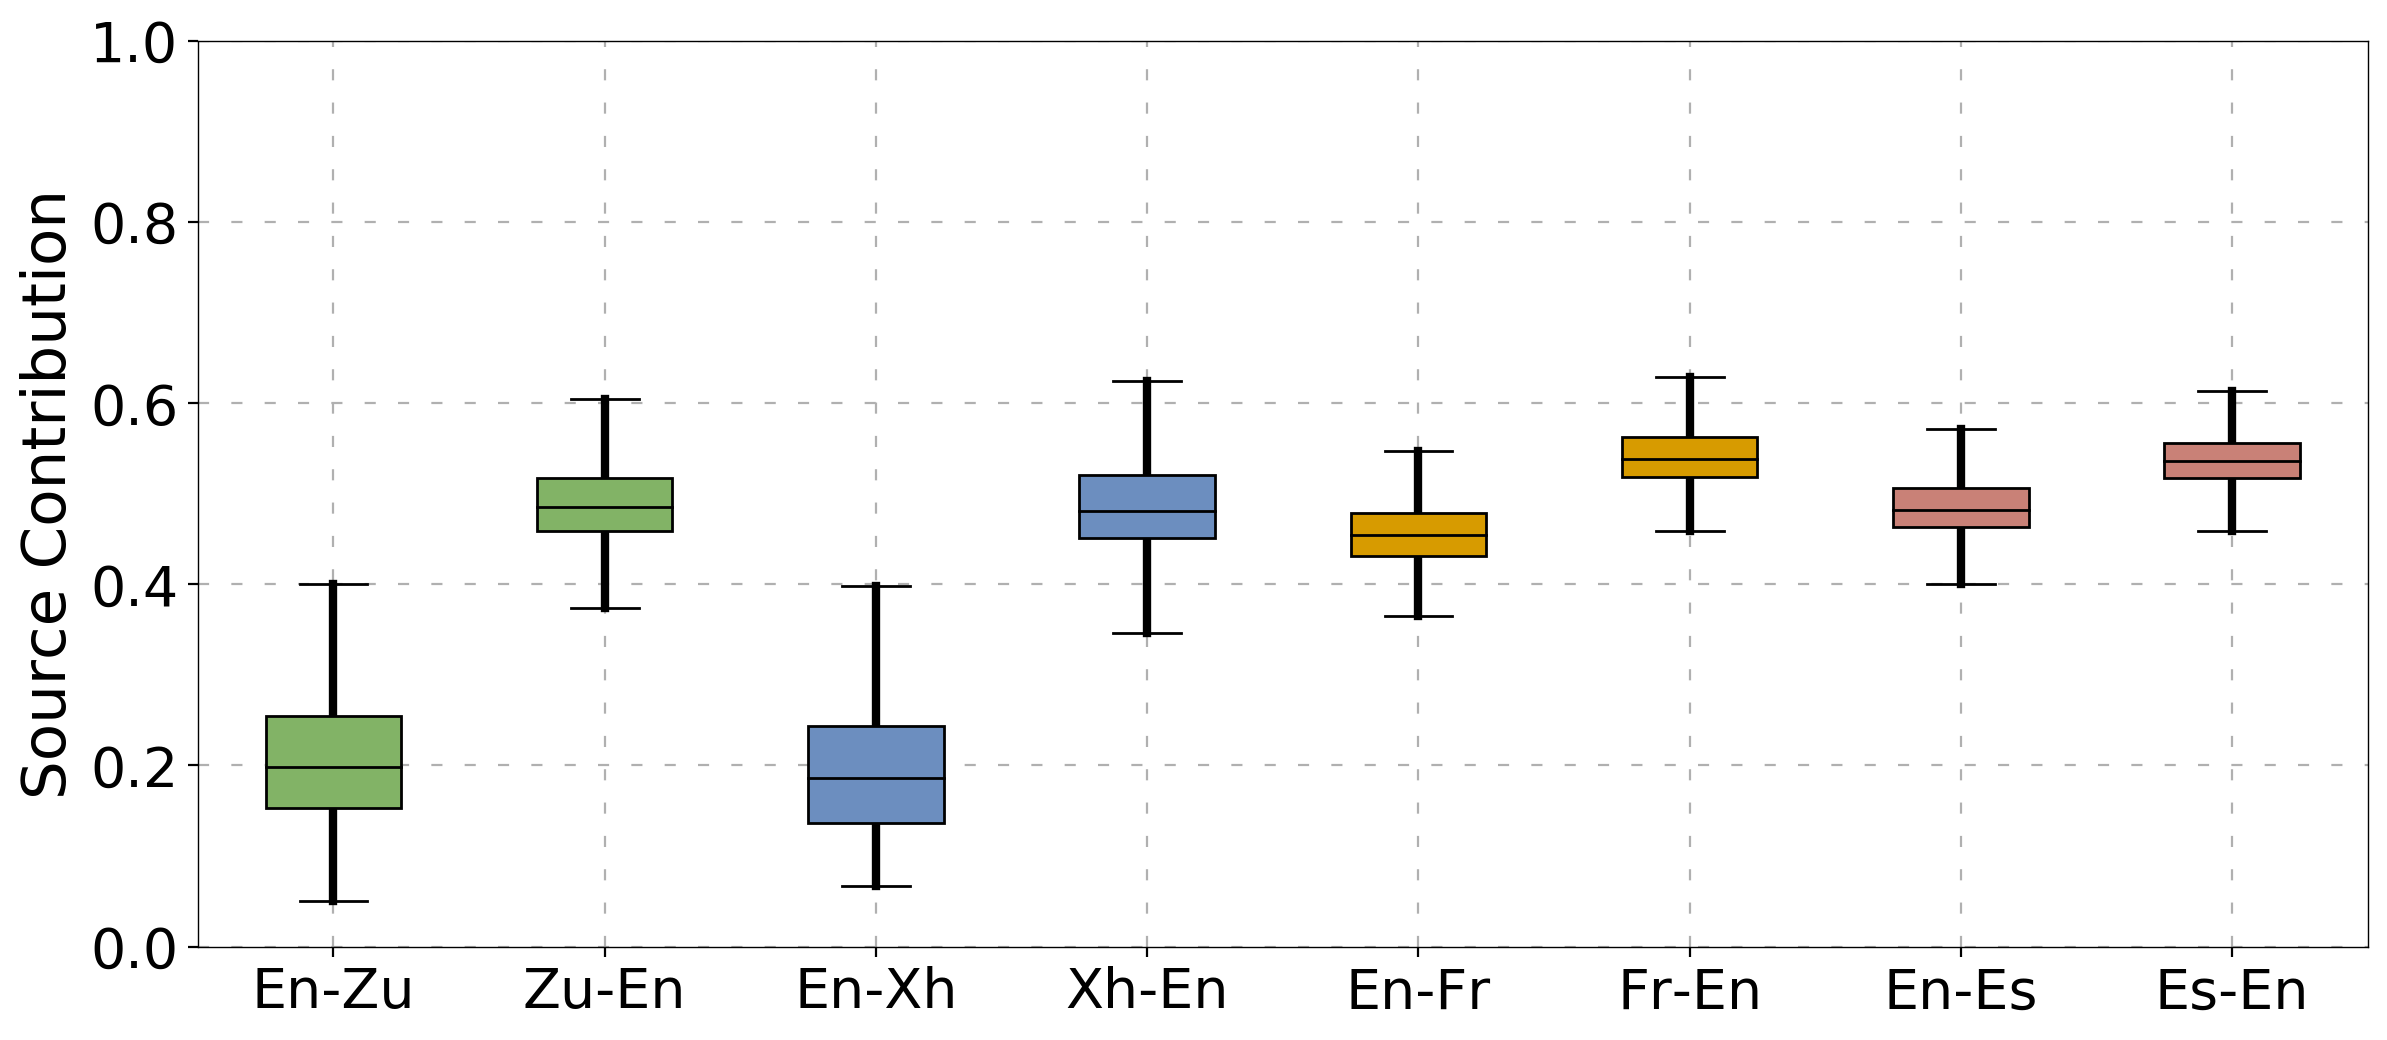

In [16]:

mean_alti = {}
for i in range(2):
    mean_alti['En-Zu']= eng_zul_flat
    mean_alti['Zu-En'] = zul_eng_flat
    mean_alti['En-Xh'] = eng_xho_flat
    mean_alti['Xh-En'] = xho_eng_flat
    #mean_alti['En-Yo'] = eng_yor_flat
    #mean_alti['Yo-En'] = yor_eng_flat
    # mean_alti['En-Ms'] = eng_msa_flat
    # mean_alti['Ms-En'] = msa_eng_flat
    mean_alti['En-Fr'] = eng_fra_flat
    mean_alti['Fr-En'] = fra_eng_flat
    mean_alti['En-Es'] = eng_spa_flat
    mean_alti['Es-En'] = spa_eng_flat
    

colors = ['#82B366','#6C8EBF','#D79B00','#C98177']
fig, ax = plt.subplots(figsize =(14, 6),dpi=200)
box = ax.boxplot(mean_alti.values(),whiskerprops=dict(linewidth=3.0),
                patch_artist=True, showfliers=False)
plt.setp(box['medians'], color='black')
counter = 0
for i, patch in enumerate(box['boxes']):
    print(patch)
    patch.set_facecolor(colors[i//2])
ax.set_xticklabels(mean_alti.keys())
ax.set_ylim(0,1)
ax.grid(True, linestyle=(0, (5, 10)))
plt.ylabel(r'Source Contribution')


## Correlation EOS vs. Residual cross-attention

In [ ]:
## First load de-en bilingual model with iwslt dataset
args = SimpleNamespace(
    src = "de",
    tgt = "en",
    tokenizer = tokenizer,
    test_set_dir = test_set_dir,
    pre_layer_norm=pre_layer_norm,
    beam = 1,
    num_layers = NUM_LAYERS
    )

## Get suitable flores sentences. Tokenized english sentences length <= 40
length_sen_eng = []
if source_lang == 'en':
    lang_max = target_lang
else:
    lang_max = source_lang
print('lang_max', lang_flores_dict[lang_max])
num_sentences = 1011 # 1011
for i in range(num_sentences):
    sample = hub.get_interactive_sample(i, Path("./data/flores"), lang_flores_dict[lang_max], 'eng', 'spm')
    src_tok_len = len(sample['src_tok'])
    if src_tok_len <= 50:
        length_sen_eng.append(i)
contributions = True

eos_dict, res_dict = helper.model_analysis(hub, length_sen_eng, args,
                                            eos_res_corr=True, lang_toks=False,
                                            src_contrib=False)

In [21]:
corr_dict = defaultdict(list)
res_dict_list = defaultdict(list) # each layer has one list
for layer in range(NUM_LAYERS):
    eos_list = [item for sublist in eos_dict[layer] for item in sublist]
    res_list = [item for sublist in res_dict[layer] for item in sublist]
    res_dict_list[layer] = res_list
    #punct_list = [item for sublist in punct_list for item in sublist]

    from scipy.stats.stats import pearsonr
    corr_dict[layer] = pearsonr(eos_list, res_list)[0]
    # outfile = f'./results/{model}_{dataset}_eos_res_corr.json'

    # with open(outfile, 'w') as f:
    #     json.dump(corr_dict, f)  
    

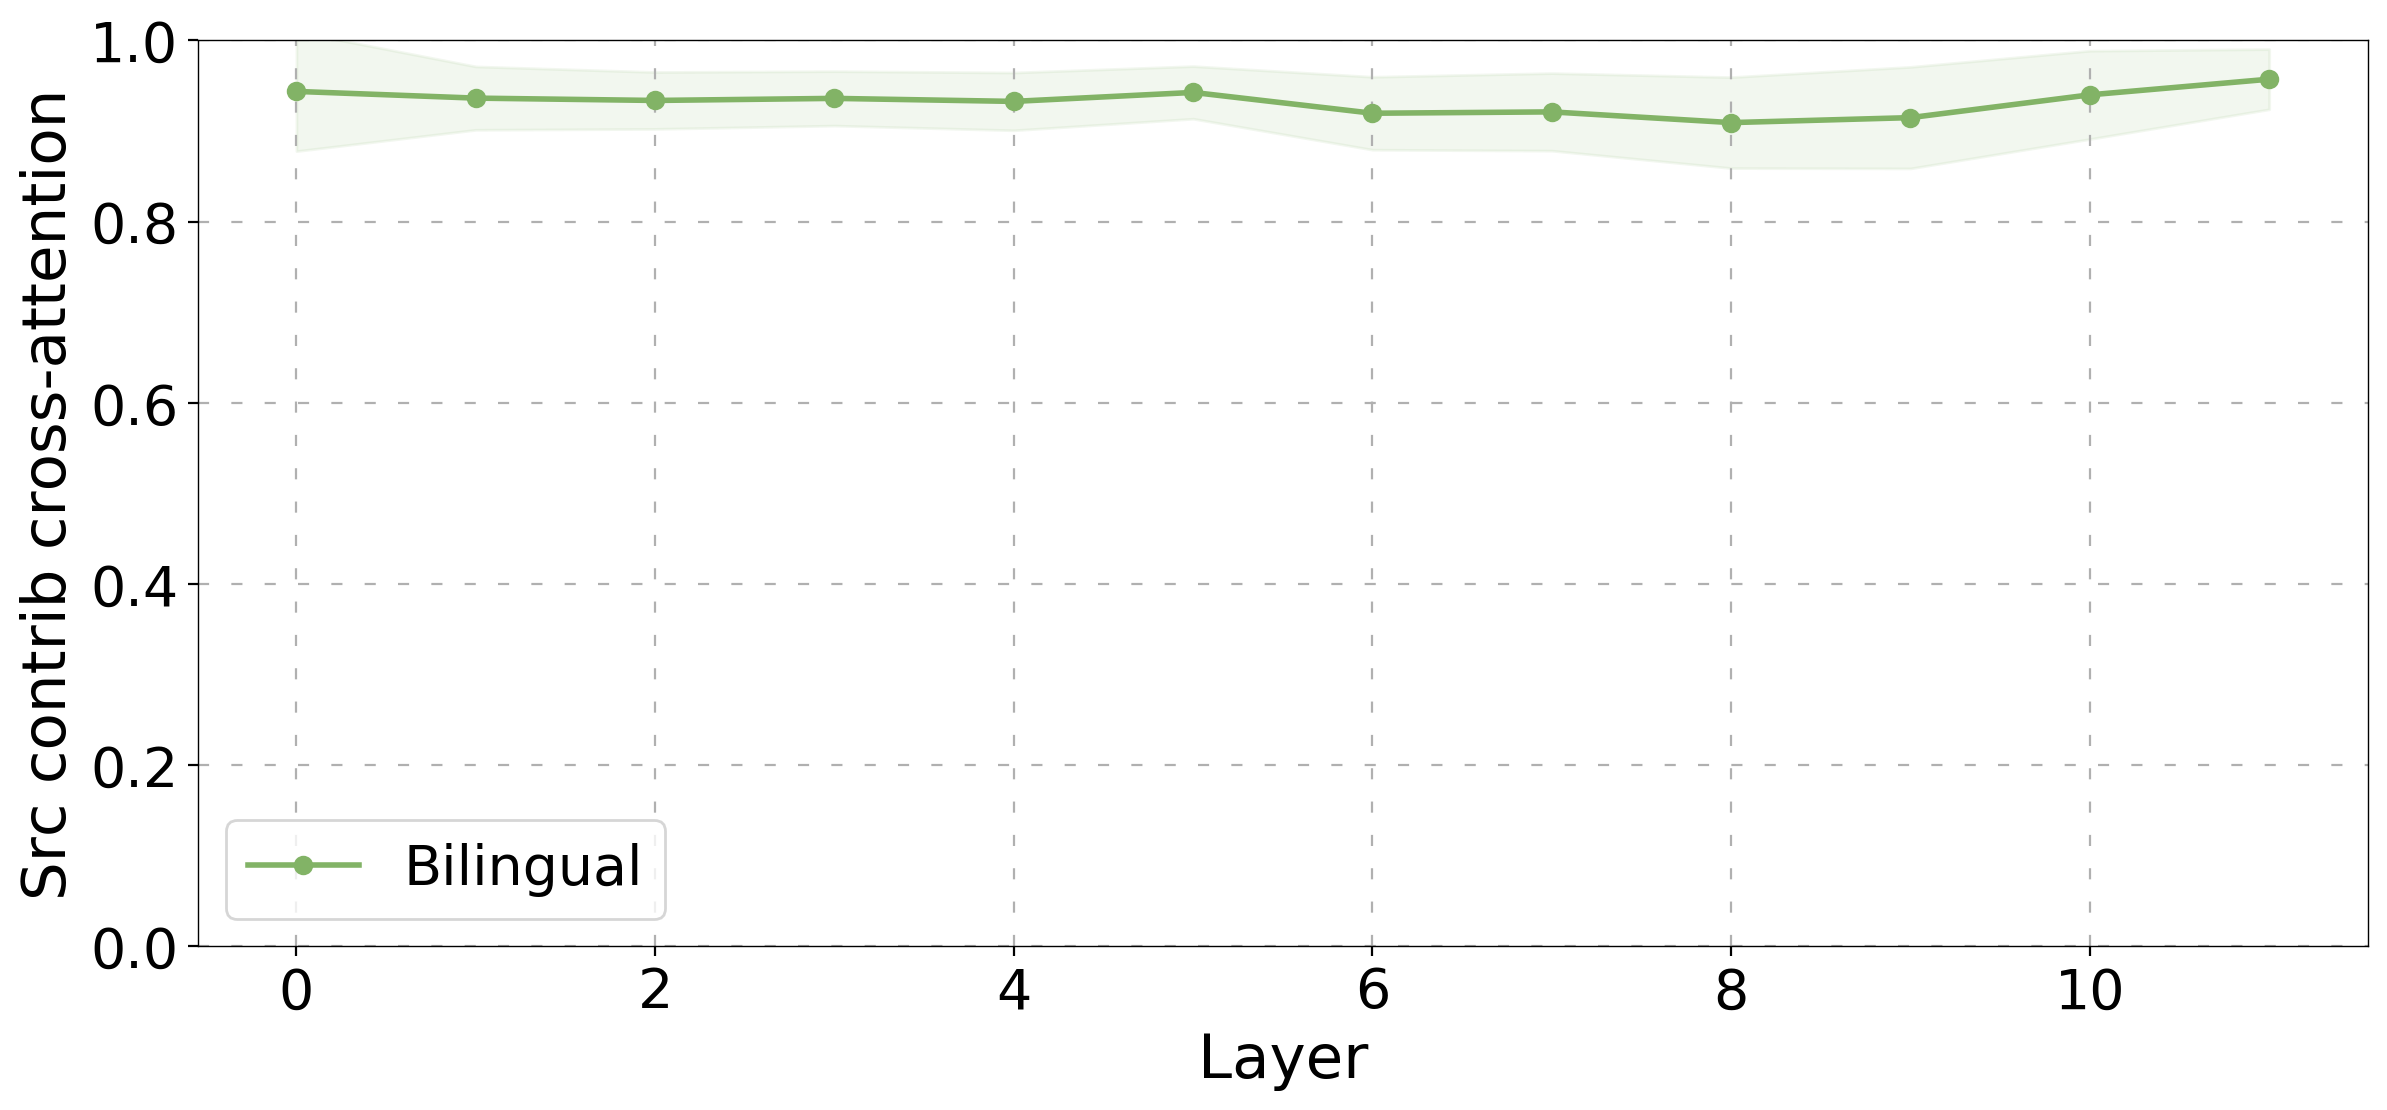

In [22]:
data = [0]*2
x_ticks = [0]*2
x_ticks[0], data[0] = [*zip(*res_dict_list.items())]  # 'transpose' items to parallel key, value lists
#x_ticks[1], data[1] = [*zip(*mix_dict_multilingual.items())]  # 'transpose' items to parallel key, value lists

#x_ticks = [1,2,3,4,5,6]
color = ['#82B366','#6C8EBF','#D79B00']
labels = ['Bilingual', 'Multilingual']
# Creating plot 
#fig = plt.figure(figsize =(20, 7)) 
fig, ax = plt.subplots(figsize =(14, 6),dpi=200)

for i in range(1):
    mean_data = [statistics.mean(j) for j in data[i]] # mean per head
    std_data = [statistics.stdev(j) for j in data[i]] # std per head
    ax.plot(x_ticks[i], mean_data, color[i], markersize=6, linewidth=2, linestyle='-',alpha = 1, marker='o',label=labels[i])
    ax.fill_between(x_ticks[i], (np.array(mean_data)-np.array(std_data)), (np.array(mean_data)+np.array(std_data)), color=color[i], alpha=.1)


ax.set_ylim(0,1)
plt.xlabel('Layer')
plt.ylabel('Src contrib cross-attention')
ax.legend(prop={'size': 20})
ax.grid(True, linestyle=(0, (5, 10)));

In [7]:
outfile = f'./results/bilingual_iwslt_eos_res_corr.json'
f = open(outfile)
corr_dict_bilingual = json.load(f)
outfile = f'./results/multilingual_iwslt_eos_res_corr.json'
f = open(outfile)
corr_dict_multilingual = json.load(f)

<class 'tuple'>
[1 2 3 4 5 6]


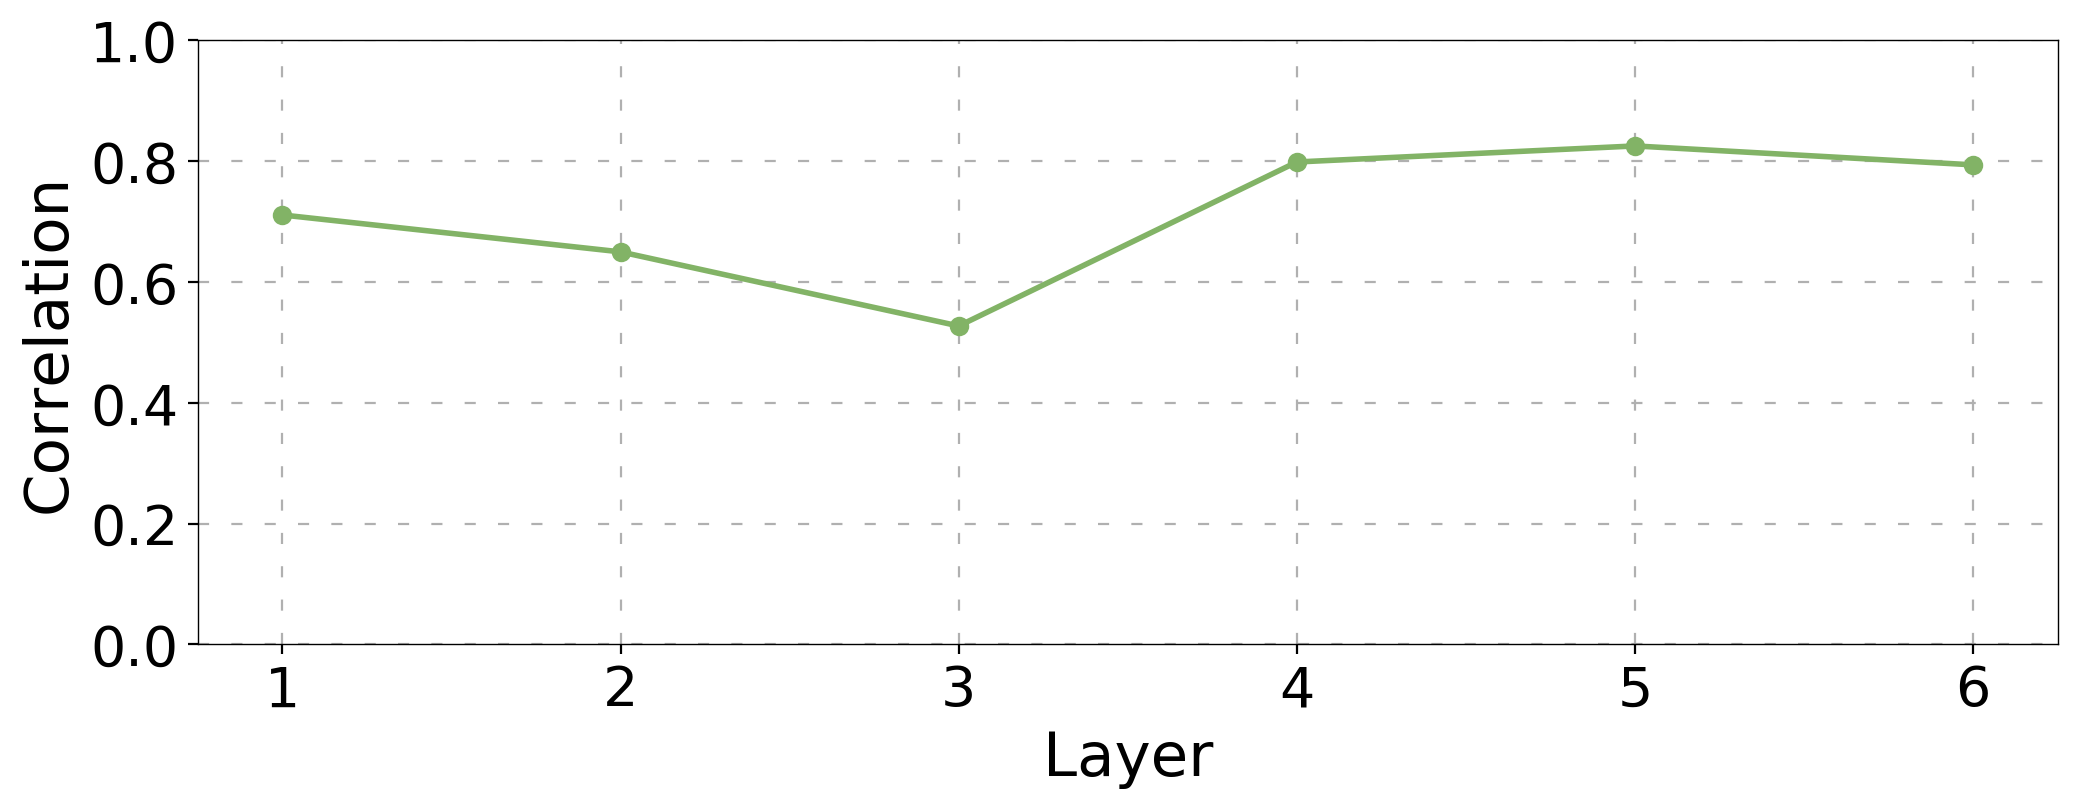

In [25]:

data = [0]*2
x_ticks_list = [0]*2
x_ticks_list[0], data[0] = [*zip(*corr_dict_bilingual.items())]  # 'transpose' items to parallel key, value lists
x_ticks_list[1], data[1] = [*zip(*corr_dict_multilingual.items())]  # 'transpose' items to parallel key, value lists

x_ticks = np.arange(1,7)
color = ['#82B366','#6C8EBF']#,'#D79B00']
labels = ['Bilingual', 'Multilingual']
# Creating plot 
#fig = plt.figure(figsize =(20, 7)) 
fig, ax = plt.subplots(figsize =(12, 4),dpi=200)

for i in range(1):
    print(type(data[i]))
    print(x_ticks)
    ax.plot(x_ticks, data[i], 'b', markersize=6, linewidth=2,
            linestyle='-',alpha = 1, marker='o',color=color[i],
            label = labels[i])


ax.set_ylim(0,1)
plt.xlabel('Layer')
plt.ylabel(r'Correlation')
ax.grid(True, linestyle=(0, (5, 10)))
#plt.grid(False, linewidth=0.25);
#plt.legend(prop={'size': 16})
#ax.legend(loc=(0.05,0.12),prop={'size': 20})
# ax.set_xticks([1,2,3,4]);
# ax.set_yticks([1,2,3,4]);
#ax.set_xticklabels(x_ticks);

## Encoder mixing Analysis

In [12]:
# dataset = 'iwslt'
# if dataset == 'iwslt':
#     test_set_dir = iwslt14_dir / "tokenized/"
# elif dataset == 'gold':
#     test_set_dir = europarl_dir / "processed_data/"

args = SimpleNamespace(
    src = "de",
    tgt = "en",
    tokenizer = tokenizer,
    test_set_dir = test_set_dir
    )
contributions = True
results_dict = defaultdict(list)
length_sentences = []

i = 0
counter = 0

while counter < 1000:
    if counter%100==0:
        print(counter)
    sample = hub.get_interactive_sample(i, args.test_set_dir, args.src, args.tgt, args.tokenizer)
    src_tensor = sample['src_tensor']
    src_tok = sample['src_tok']
    if len(src_tok)>50:
        i += 1
        continue
    #     relevances_enc_self_attn = hub.get_contribution_rollout(src_tensor, tgt_tensor, 'l1', norm_mode='min_sum')['encoder.self_attn']
    length_sentences.append(len(src_tok))
    tgt_tensor, _ = get_greedy_decoding(hub, src_tensor)

    relevances_enc_self_attn = hub.get_contribution_rollout(src_tensor, tgt_tensor, 'l1',
                                                            norm_mode='min_sum',
                                                            pre_layer_norm=pre_layer_norm)['encoder.self_attn']
    relevances_enc_self_attn = relevances_enc_self_attn.detach().cpu()
    
    for layer in range(NUM_LAYERS):
        total_contrib = relevances_enc_self_attn[layer].sum()
        diag_sum = torch.diagonal(relevances_enc_self_attn[layer]).sum()
        #key = f'{layer}'
        results_dict[layer].append((diag_sum/total_contrib).numpy().item())
    #results_dict['stds'].append(torch.diagonal(relevances_enc_self_attn[-1]).std().item())
    

    counter += 1
    i += 1

    #total_rollout = hub.get_contribution_rollout(src_tensor, tgt_tensor, 'l1', norm_mode='min_sum')['total'].detach()


0
0
0
100
100
200
300
400
500
600
700
700
800
900


In [13]:
# results_dict_lists = defaultdict(list)
# for key in results_dict.keys():
#     results_dict_lists[key] = [float(v) for v in results_dict[key]]


In [15]:
outfile = f'./results/{model}_{dataset}_encoder_mixing.json'
with open(outfile, 'w') as f:
    json.dump(results_dict, f)

In [16]:
outfile = f'./results/bilingual_iwslt_encoder_mixing.json'
f = open(outfile)
mix_dict_bilingual = json.load(f)
outfile = f'./results/multilingual_iwslt_encoder_mixing.json'
f = open(outfile)
mix_dict_multilingual = json.load(f)

In [17]:
plt.rcParams.update({'font.size': 30})
plt.rcParams.update({'xtick.labelsize' : 20})
plt.rcParams.update({'ytick.labelsize' : 20})
plt.rcParams.update({'axes.titlesize' : 24})
plt.rcParams.update({'axes.labelsize' : 22})

[0.7679682889580727, 0.6271107321381569, 0.5570064037740231, 0.4939672894477844, 0.44153269213438034, 0.4065199926495552]
[0.9505528939962387, 0.8963968846201896, 0.8468149383664131, 0.8014466289281845, 0.7569965806603431, 0.7100233145356178, 0.6548033846020699, 0.6088981763124466, 0.5583705756366253, 0.5200965020358562, 0.49163996762037276, 0.46979292926192284]


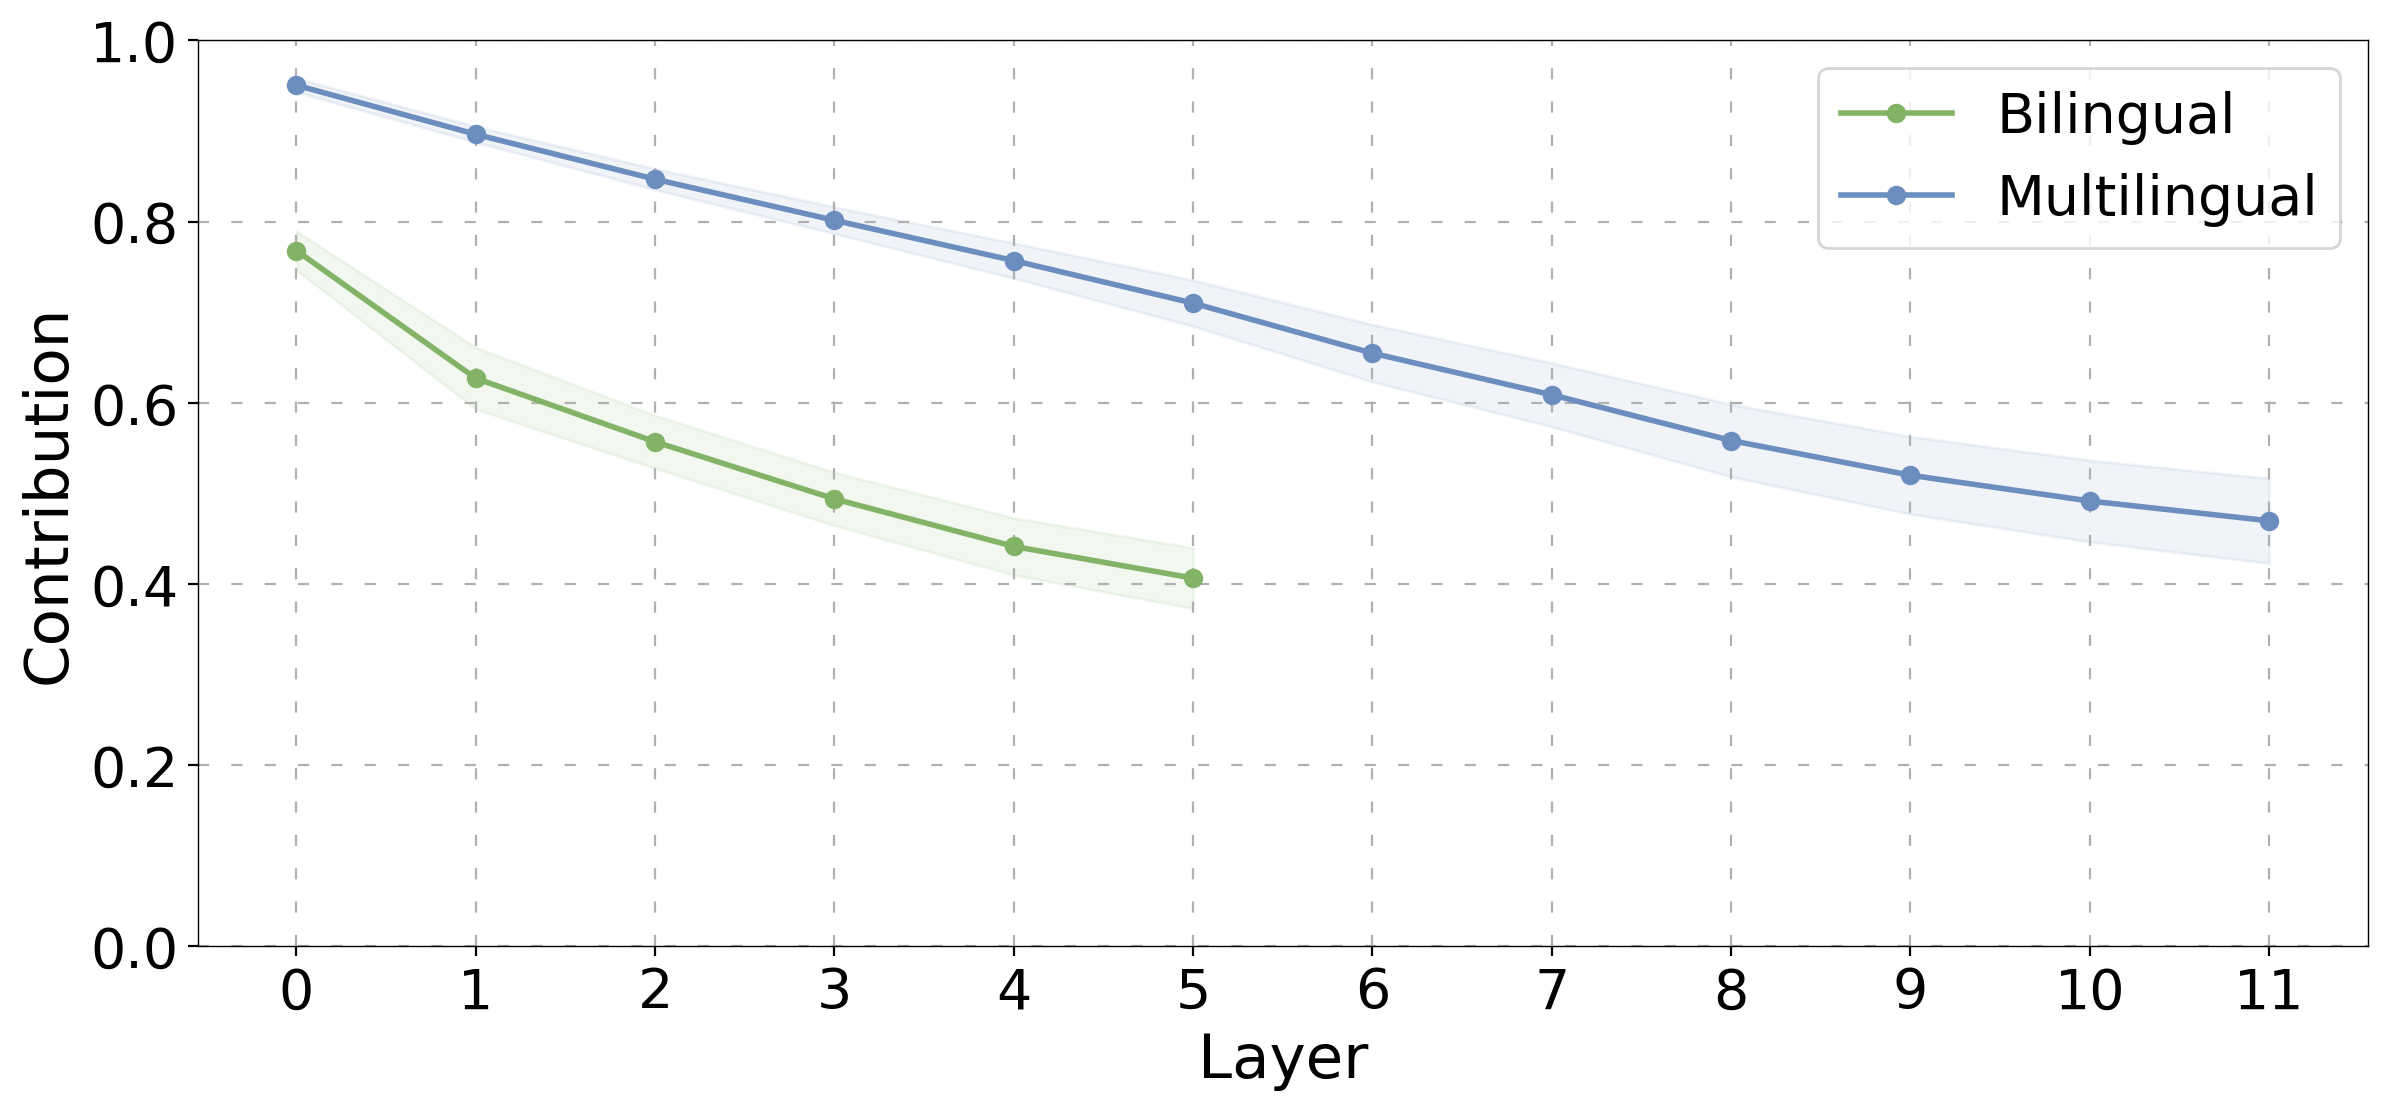

In [18]:
data = [0]*2
x_ticks = [0]*2
x_ticks[0], data[0] = [*zip(*mix_dict_bilingual.items())]  # 'transpose' items to parallel key, value lists
x_ticks[1], data[1] = [*zip(*mix_dict_multilingual.items())]  # 'transpose' items to parallel key, value lists

#x_ticks = [1,2,3,4,5,6]
color = ['#82B366','#6C8EBF','#D79B00']
labels = ['Bilingual', 'Multilingual']
# Creating plot 
#fig = plt.figure(figsize =(20, 7)) 
fig, ax = plt.subplots(figsize =(14, 6),dpi=200)

for i in range(2):
    mean_data = [statistics.mean(j) for j in data[i]] # mean per head
    print(mean_data)
    std_data = [statistics.stdev(j) for j in data[i]] # std per head
    ax.plot(x_ticks[i], mean_data, color[i], markersize=6, linewidth=2, linestyle='-',alpha = 1, marker='o',label=labels[i])
    ax.fill_between(x_ticks[i], (np.array(mean_data)-np.array(std_data)), (np.array(mean_data)+np.array(std_data)), color=color[i], alpha=.1)


ax.set_ylim(0,1)
plt.xlabel('Layer')
plt.ylabel('Contribution')
#plt.legend(prop={'size': 16})
#ax.legend(loc=(0.05,0.12),prop={'size': 20})
ax.legend(prop={'size': 20})
ax.grid(True, linestyle=(0, (5, 10)));
#plt.grid(False, linewidth=0.25)

#ax.grid(True)
#ax.set_xticks([1,2,3,4,5,6]);
#ax.set_yticks([1,2,3,4,5,6]);
#ax.set_xticklabels(x_ticks);

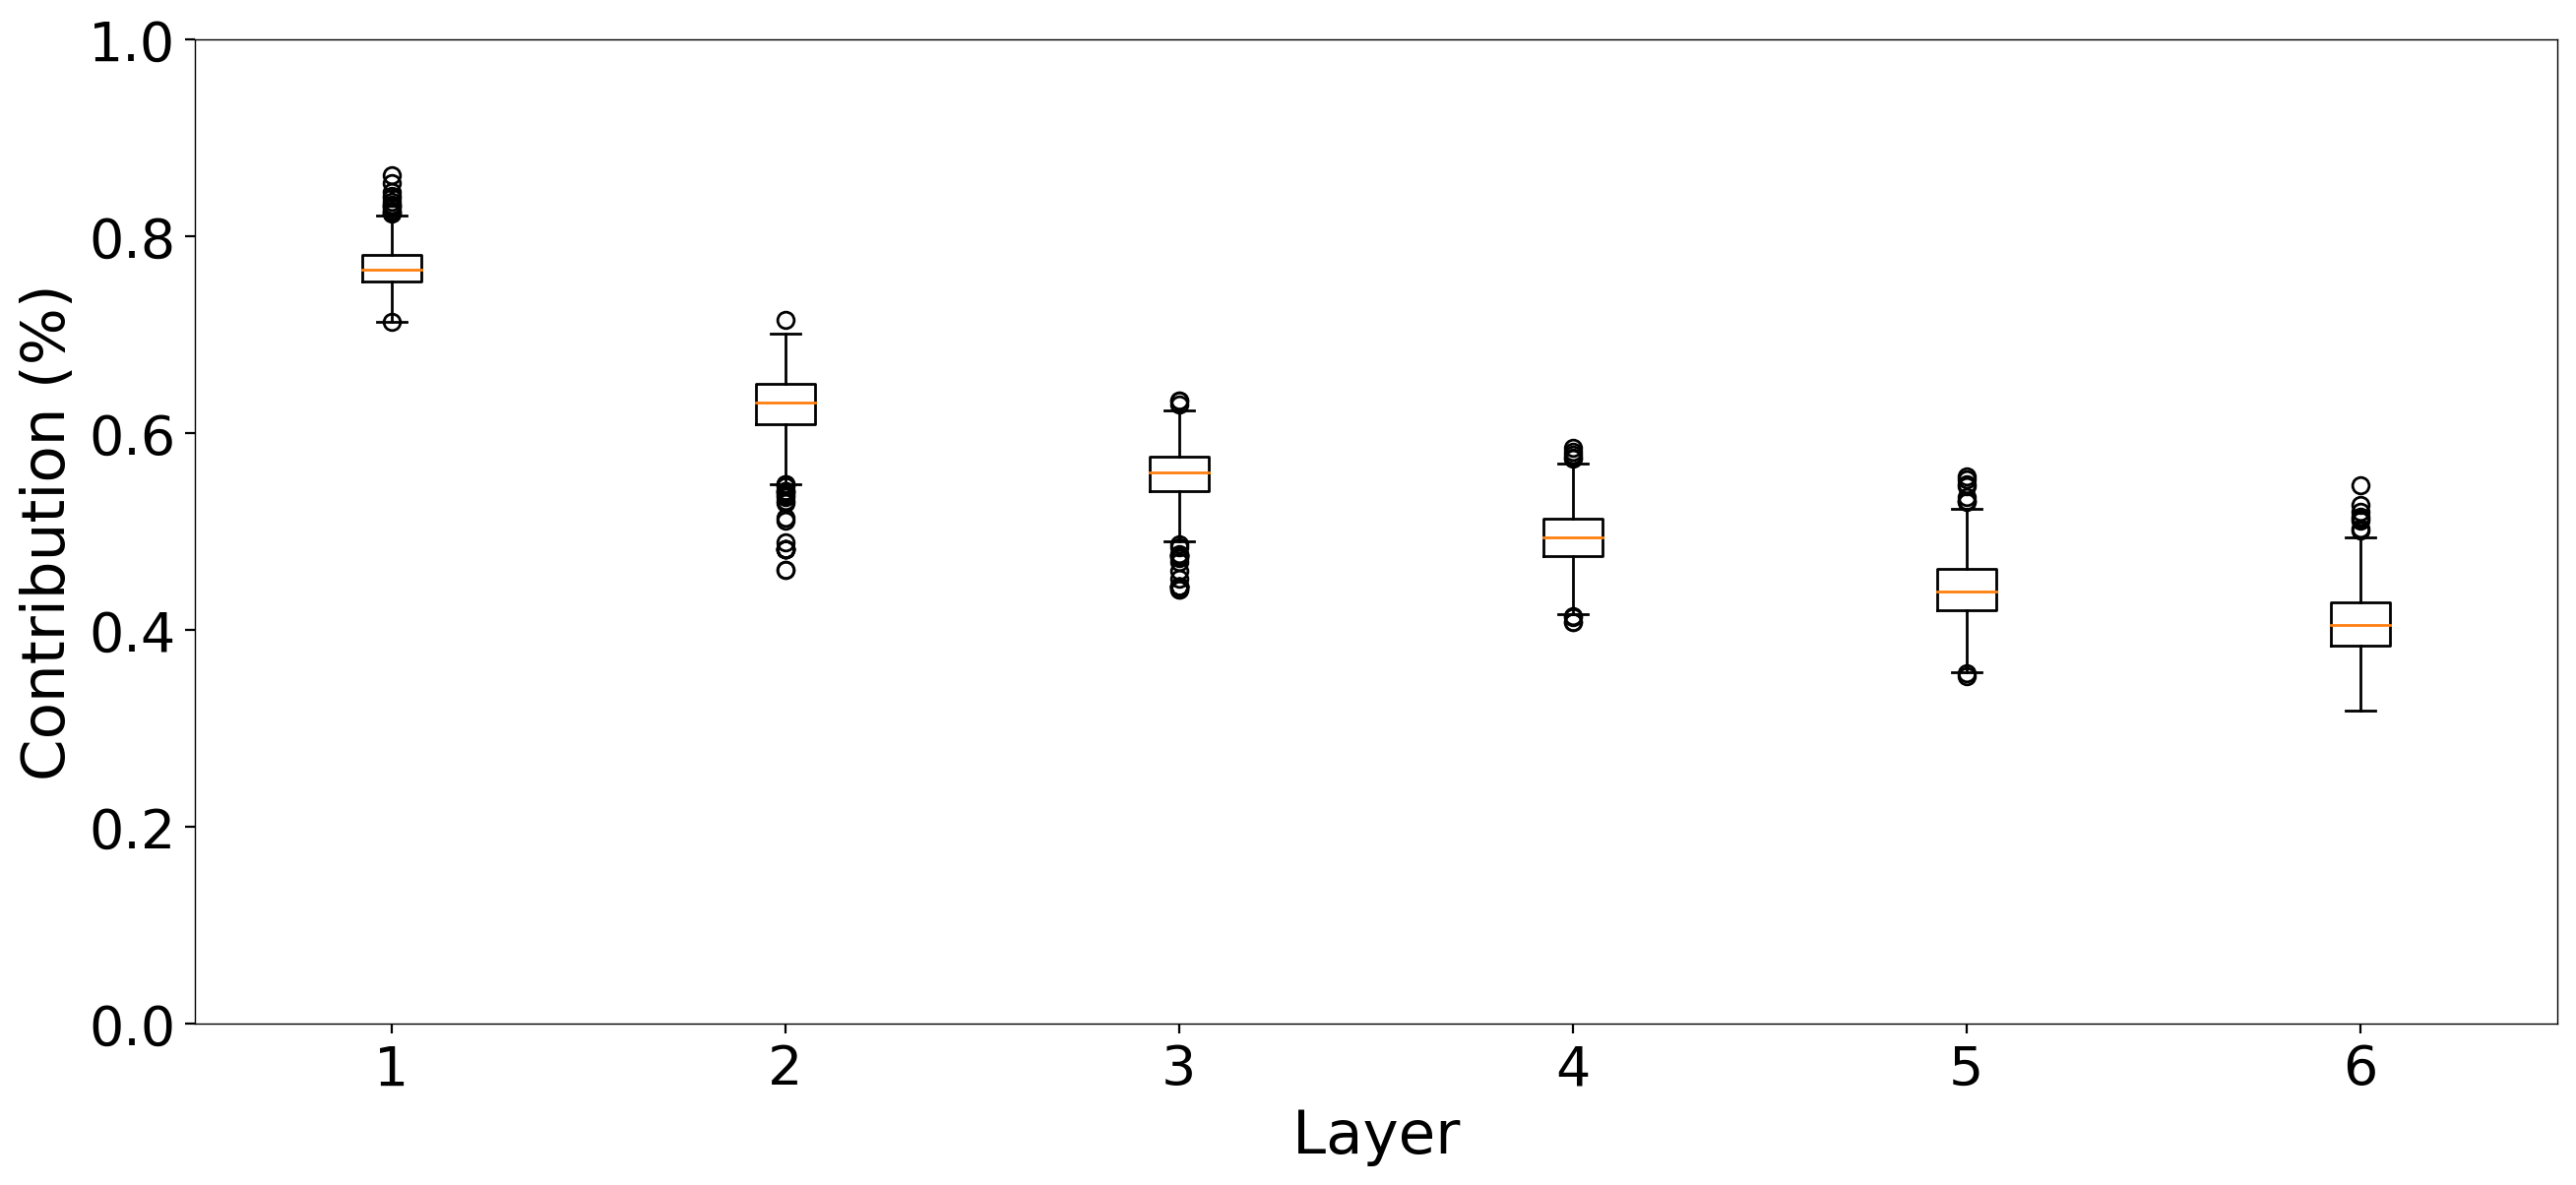

In [12]:
fig = plt.figure(figsize =(12, 5),dpi=200)
 
# Creating axes instance
ax = fig.add_axes([0, 0, 1, 1])
for i in range(1,7):
    ax.boxplot(results_dict[i], positions = [i])
# Creating plot
#bp = ax.boxplot(data_4)
ax.set_ylim(0,1)
plt.xlabel('Layer')
plt.ylabel('Contribution (%)')
#plt.grid(True)
# show plot
plt.show()

<Figure size 2000x2000 with 0 Axes>

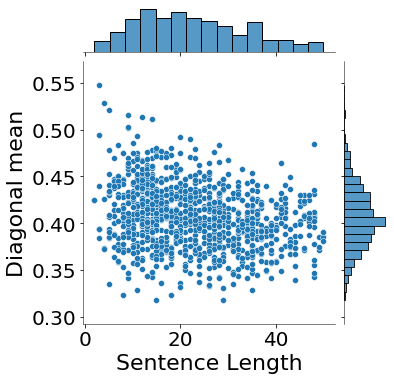

In [ ]:
dict_data = {'Diagonal mean':results_dict['means'], 'Sentence Length':length_sentences}
df = pd.DataFrame(dict_data)
plt.figure(figsize=(10,10),dpi=200)
#df.plot.scatter(x = 'length', y = 'means');
sns.jointplot(x=df["Sentence Length"], y=df["Diagonal mean"], kind='scatter')


In [13]:
total_sentences = len(results_dict['means'])
print(f'Total of {total_sentences} sentences')
print('Mean: ', statistics.mean(results_dict['means']))
print('Std: ', statistics.mean(results_dict['stds']))

Total of 1000 sentences
Mean:  0.40651998993754385
Std:  0.19392589148879052


## Values vectors analysis

In [10]:
args = SimpleNamespace(
    src = "de",
    tgt = "en",
    tokenizer = tokenizer,
    test_set_dir = test_set_dir
    )
contributions = True
alignment_layer = 4
head_dim = 128
num_heads = 4
eos_dict = defaultdict(list)
final_punct_dict = defaultdict(list)
rest_tokens_dict = defaultdict(list)

i = 0
counter = 0

while counter < 1000:
    if counter%100==0:
        print(counter)
    sample = hub.get_interactive_sample(i, args.test_set_dir, args.src, args.tgt, args.tokenizer)
    src_tensor = sample['src_tensor']
    src_tok = sample['src_tok']
    if len(src_tok)>50:
        i += 1
        continue
    # if len(src_tok)>20 and len(src_tok)<23:
    #     relevances_enc_self_attn = hub.get_contribution_rollout(src_tensor, tgt_tensor, 'l1', norm_mode='min_sum')['encoder.self_attn']
        
    tgt_tensor, _ = get_greedy_decoding(hub, src_tensor)

    model_output, log_probs, encoder_out, layer_inputs, layer_outputs = hub.trace_forward(src_tensor, tgt_tensor)
    values = torch.squeeze(layer_outputs[f'models.0.decoder.layers.{alignment_layer}.encoder_attn.v_proj'][0]).detach().cpu()
    v = torch.squeeze(values.contiguous().view(-1, num_heads, head_dim).transpose(0, 1)) # heads,src_len,128
    eos_value = v[:,-1,:]
    final_punct_value = v[:,-2,:]
    rest_tokens_value = v[:,:-2,:]
    
    #random_value = values[-3]
    
    for head in range(num_heads):
        eos_dict[head].append(eos_value[head].norm(dim=-1).tolist())
        final_punct_dict[head].append(final_punct_value[head].norm(dim=-1).tolist())
        rest_tokens_dict[head].append(rest_tokens_value[head].norm(dim=-1).mean().tolist())
    
    counter += 1
    i += 1

    #total_rollout = hub.get_contribution_rollout(src_tensor, tgt_tensor, 'l1', norm_mode='min_sum')['total'].detach()


0
0
0
100
200
300
400
500
600
600
600
700
800
800
900


In [13]:
plt.rcParams.update({'font.size': 30})
plt.rcParams.update({'xtick.labelsize' : 20})
plt.rcParams.update({'ytick.labelsize' : 20})
plt.rcParams.update({'axes.titlesize' : 24})
plt.rcParams.update({'axes.labelsize' : 22})

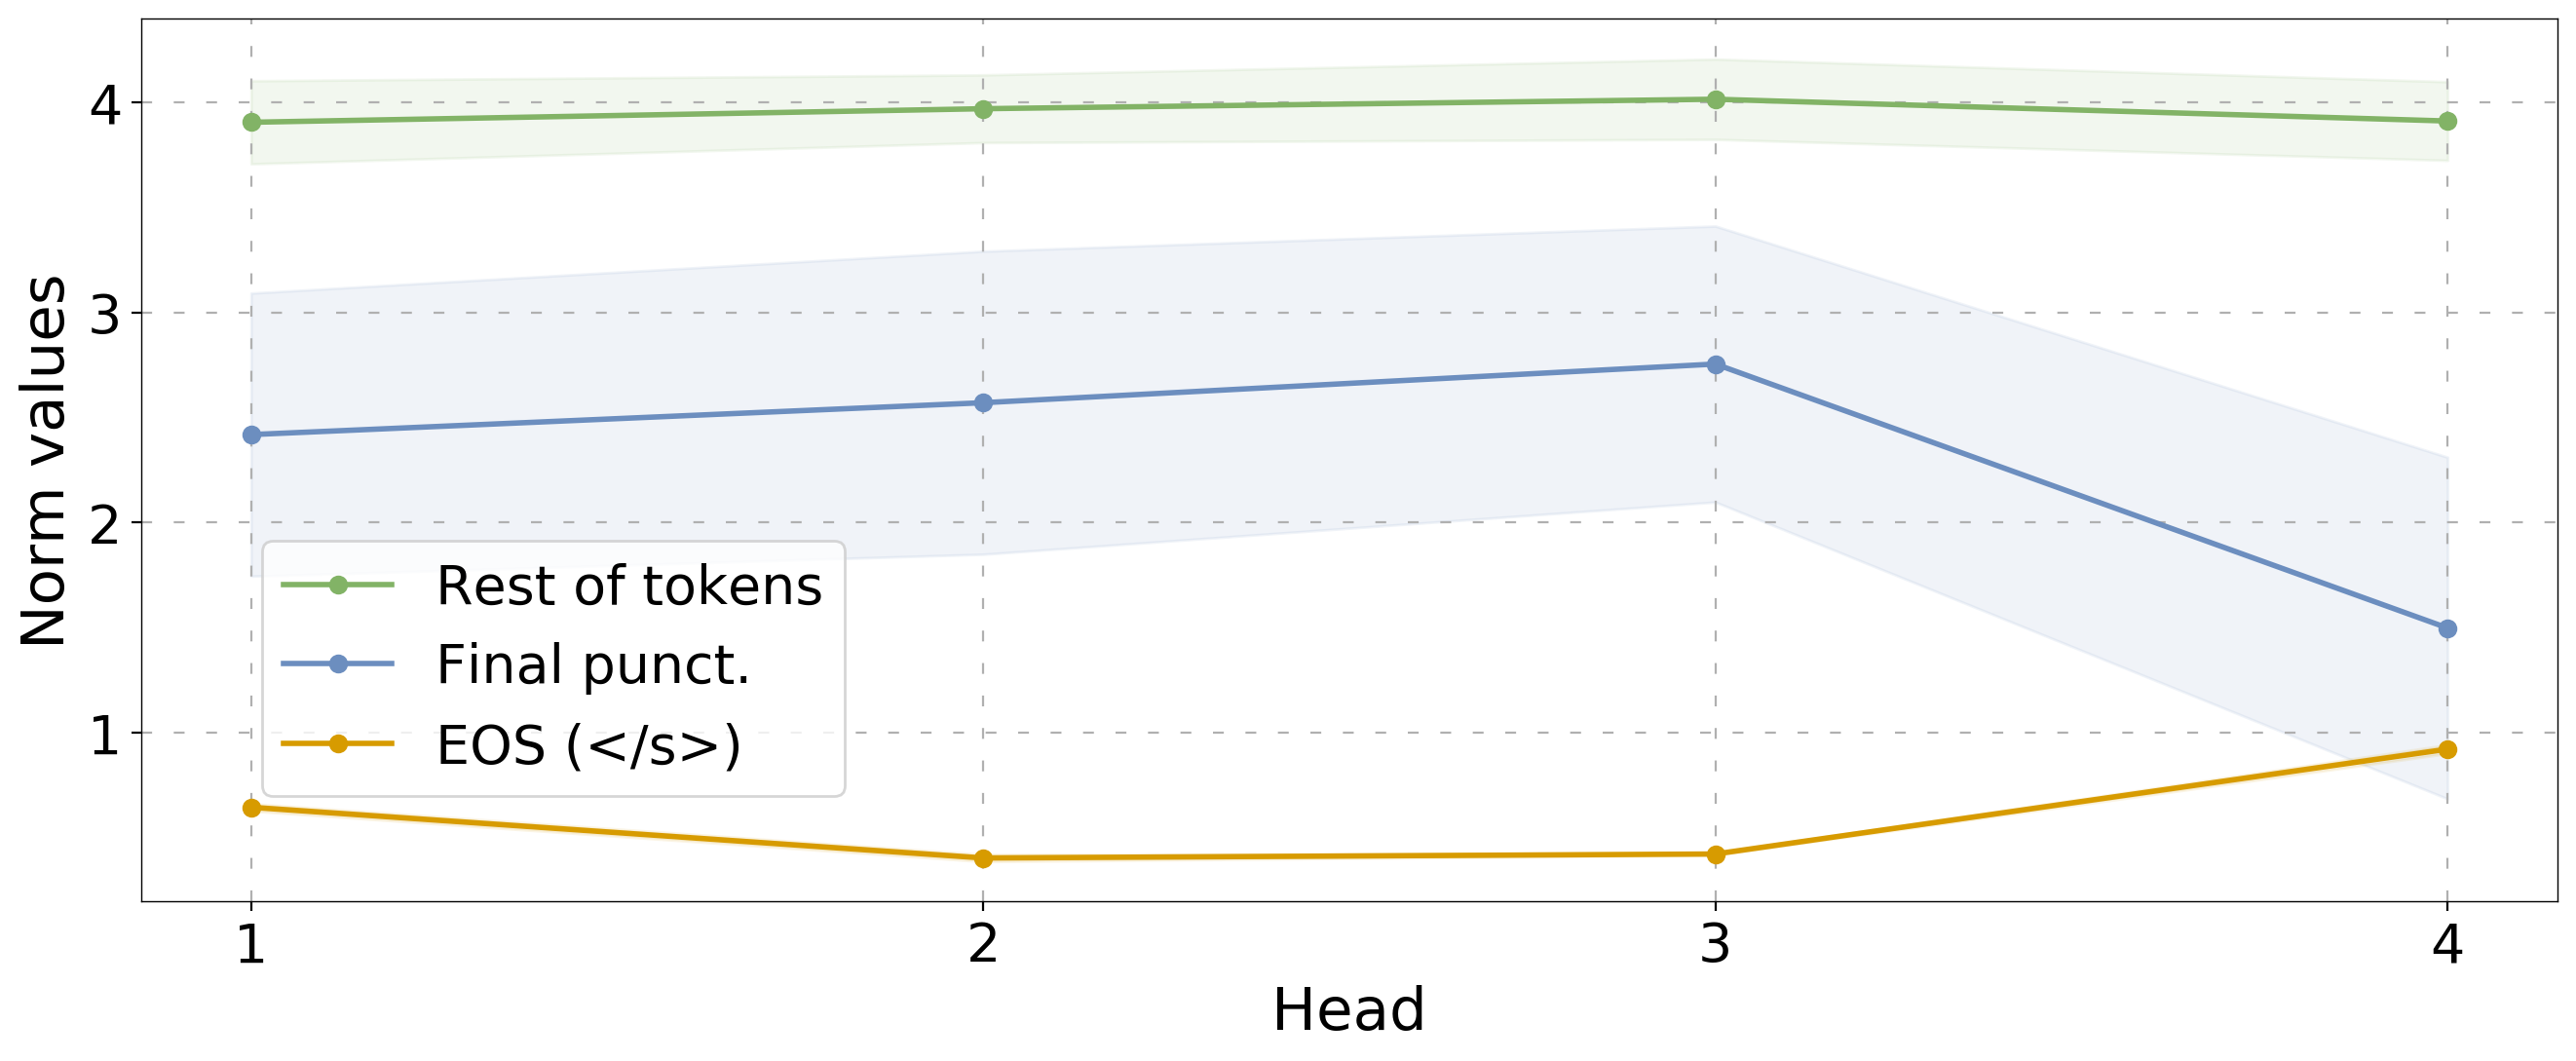

In [24]:

data = [0]*3

labels, data[2] = [*zip(*eos_dict.items())]  # 'transpose' items to parallel key, value lists
labels, data[1] = [*zip(*final_punct_dict.items())]  # 'transpose' items to parallel key, value lists
labels, data[0] = [*zip(*rest_tokens_dict.items())]  # 'transpose' items to parallel key, value lists
x_ticks = [1,2,3,4]
color = ['#82B366','#6C8EBF','#D79B00']
labels = ['Rest of tokens', 'Final punct.', 'EOS (</s>)']
# Creating plot 
#fig = plt.figure(figsize =(20, 7)) 
fig, ax = plt.subplots(figsize =(16, 6),dpi=200)
for i in range(3):
    mean_data = [statistics.mean(j) for j in data[i]] # mean per head
    std_data = [statistics.stdev(j) for j in data[i]] # std per head
    ax.plot(x_ticks, mean_data, color[i], markersize=6, linewidth=2, linestyle='-',alpha = 1, marker='o',label=labels[i])
    ax.fill_between(x_ticks, (np.array(mean_data)-np.array(std_data)), (np.array(mean_data)+np.array(std_data)), color=color[i], alpha=.1)


#ax.set_ylim(0,4)
plt.xlabel('Head')
plt.ylabel('Norm values')
#plt.legend(prop={'size': 16})
ax.legend(loc=(0.05,0.12),prop={'size': 20})
ax.grid(True, linestyle=(0, (5, 10)))
ax.set_xticks([1,2,3,4]);
#ax.set_yticks([1,2,3,4]);
#plt.grid(False, linewidth=0.25, linestyle='--');
#ax.set_xticklabels(x_ticks);

torch.Size([18, 4])


Text(0.5, 1.0, 'Norm K vectors')

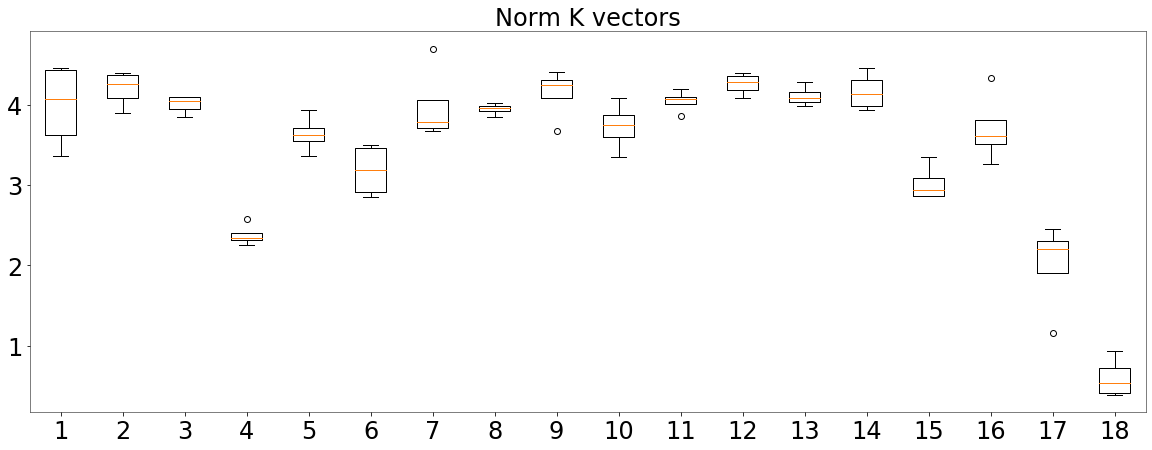

In [19]:
transformed_vectors_box = v.norm(dim=2).data
transformed_vectors_box = transformed_vectors_box.permute(1,0)
print(transformed_vectors_box.size())
  
# Creating plot 
fig = plt.figure(figsize =(20, 7)) 
ax = fig.add_subplot(111) 

ax.boxplot(transformed_vectors_box);
ax.set_title('Norm K vectors')
#ax.set_xticklabels(en_list, rotation=45, fontsize=20);